In [2]:
%matplotlib inline
import os
import math 
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import random
from scipy.stats import pearsonr
from matplotlib.colors import rgb2hex
pd.options.display.max_columns=999
from sklearn.preprocessing import scale
from statsmodels.sandbox.stats.multicomp import fdrcorrection0

sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')

workspace_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/dataframes'
ahba_dir       =  os.path.join(workspace_dir, 'AHBA')
pheno_dir      = os.path.join(workspace_dir, 'phenotypic')
clinical_dir   = os.path.join(workspace_dir, 'DF_clinical')
permute_dir    = os.path.join(workspace_dir, 'permutations')

save_fig_dir = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v4'

dpi = 300
drop_strings = ['coords_native', 'donor_names', 'struct_id', 'struct_name', 'top_struct', 'Mean', 'Median', 
                'PC1', 'PC2','PC3', 'corrected_mni_x', 'corrected_mni_y', 'corrected_mni_z']
drop_wells = [2371, 2379, 159226045, 160091500] # strital coords outside of mask


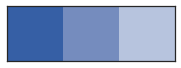

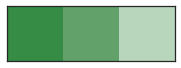

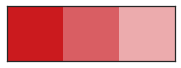

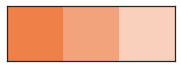

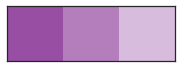

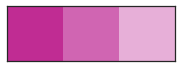

In [3]:
B=['#365fa5', '#758cbe', '#b7c4de']
G=['#368c44', '#62a26a', '#b7d6bb']
R=['#cb1a1e', '#d95e63', '#ecabad']
O=['#ef8148', '#f3a37c', '#f8d0bb']
M=['#984ea3', '#b47ebd', '#d8bcde']
P=['#c02c93', '#d065b2', '#e7afd8']

sns.palplot(sns.color_palette(B))
sns.palplot(sns.color_palette(G))
sns.palplot(sns.color_palette(R))
sns.palplot(sns.color_palette(O))
sns.palplot(sns.color_palette(M))
sns.palplot(sns.color_palette(P))


# Striatal Glu vs Suceptibility correlations 

In [4]:
def get_df(popname):
    df = pd.read_csv(os.path.join(pheno_dir, 'df_%s_qc.csv'%popname),index_col = 0)
    return df 

controls = get_df('controls')
patients = get_df('patients')



In [35]:
def detect_outlier_subjects(df,measure,m=2):
    upper = np.mean(df[measure]) + m * np.std(df[measure])
    lower = np.mean(df[measure]) - m * np.std(df[measure])
    outliers = []
    for subject in df.index:
        if df.loc[subject][measure] > upper:
            outliers.append(subject) 
        elif df.loc[subject][measure] < lower:
            outliers.append(subject) 
    #print outliers,measure
    return outliers


def plot_partial_correlation(data, x, y,xlim = None, ylim = None, regressors = None, color = None, annotate = 0, fig_name = None, 
                             dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1,
                             plot_marg = 1, ci = 95, lstyle='-',lw=2.5, label = None):
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    df = pd.concat([df_reg, data[x], data[y]], axis=1).dropna()
    
    # inititlize grid and plot regression and margins 
    grid = sns.JointGrid(x, y, data=df,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
    
    if plot_marg:
        grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, fit_reg=fit_reg, scatter= scatter, color = color, x_partial = df[regressors], y_jitter = jitter, 
                    ci = ci, line_kws={'linestyle': lstyle, 'lw':lw}, scatter_kws={"s": 25})
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
    
    ## calculate regression parameters 
    
    formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 7)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    
    if label:
        plt.ylabel(y)
        plt.xlabel(x)
    else:
        grid.set_axis_labels()
        
    if annotate == 1:
        annotate = (plt.xlim()[1]*0.6,  plt.ylim()[1]*0.95)
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    elif annotate == 0:
        pass
    else:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    
    
    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)
    

    print pcor, p_val
    return result


In [36]:
detect_outlier_subjects(controls,'STR_Gln_Glu',2)
detect_outlier_subjects(patients,'STR_Gln_Glu',2)


['TT3P', 'KDDP']

0.721 0.0037216
0.255 0.4499115
0.583 0.0022437


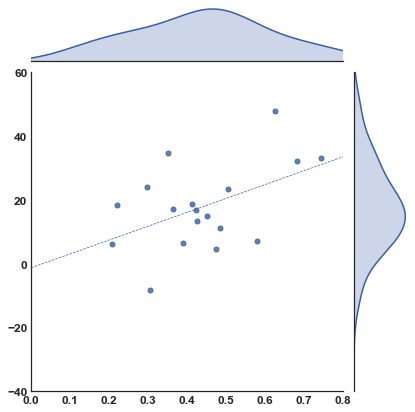

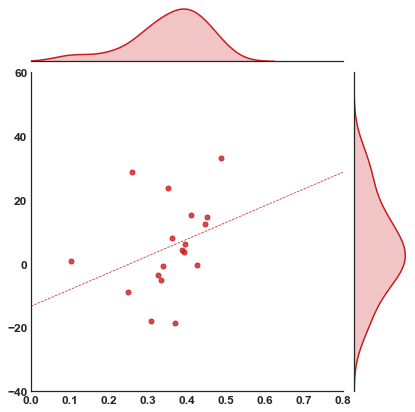

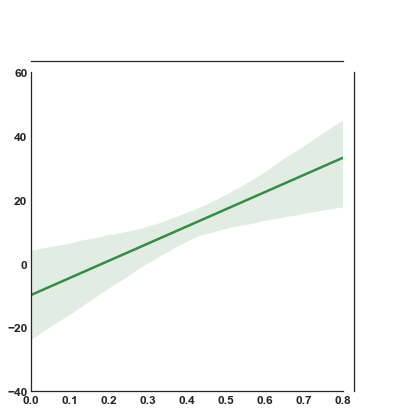

In [37]:
drop_p = ['TT3P', 'KDDP']
drop_c = []
df_all = pd.concat([controls, patients], axis =0).drop(drop_p + drop_c, axis = 0)

x = 'STR_Gln_Glu'
y = 'Caud_Puta'
regressorsx = ['Age', 'Gender', 'QC_PCA','STR_FWHM']
xlim  = (0, 0.8)
ylim  = (-40,60)

plot_partial_correlation(controls.drop(drop_c,axis=0), x, y, regressors = regressorsx, color = B[0], ci = None,
                         labels = False, lstyle='--', lw=0.7, #annotate = (0.5,0.045),
                         fit_reg=1, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, label = 0,
                         fig_name = 'corr_mrs_chi_str_controls.png'
                        )

plot_partial_correlation(patients.drop(drop_p,axis=0), x, y, regressors = regressorsx, color = R[0], ci = None,
                         labels = False, lstyle='--', lw=0.7, #annotate = (0.3,0.045),
                         fit_reg=1, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, label = 0,
                         fig_name = 'corr_mrs_chi_str_patients.png'
                        )

plot_partial_correlation(df_all, x, y, regressors = regressorsx, color = G[0], 
                         labels = False,  #annotate = (0.5,0.035),
                         fit_reg=True, scatter=0, plot_marg = 0, dpi = dpi, xlim=xlim,ylim=ylim, label = 0,
                         fig_name = 'corr_mrs_chi_str_all.png'
                        )

# Striatal Iron-Transport vs ANMC/TCA correlations 

In [38]:
def return_expression_df(geneset):
    df = pd.read_csv(os.path.join(ahba_dir, 'AHBA_%s.csv'%geneset),index_col=0)
    gs = [i for i in df.columns if i not in drop_strings]
    return df, gs 

IRON_H,  GS_IRON_H   = return_expression_df('IRON_HOMEOSTASIS_PCA')
IRON_D,  GS_IRON_D   = return_expression_df('IRON_D_PCA')
IRON_T2, GS_IRON_T2  = return_expression_df('IRON_TRANSPORT2_PCA')
FERRITIN,GS_FERRITIN = return_expression_df('FERRITIN_PCA')
IRON_IM, GS_IRON_IM  = return_expression_df('IRON_ION_IMPORT_PCA')
IRON_T1, GS_IRON_T1  = return_expression_df('IRON_TRANSPORT1_PCA')
IRON_R,  GS_IRON_R   = return_expression_df('IRON_RESPONSE_PCA')
ANMC,    GS_ANMC     = return_expression_df('ANMC_PCA')
TCA,     GS_TCA       = return_expression_df('TCA_PCA')

genesets = {'IRON_H'  : GS_IRON_H,
            'IRON_D'  : GS_IRON_D,
            'IRON_H'  : GS_IRON_H,
            'IRON_T2' : GS_IRON_T2,
            'FERRITIN': GS_FERRITIN,
            'IRON_IM' : GS_IRON_IM,
            'IRON_R'  : GS_IRON_R,
            'ANMC'    : GS_ANMC,
            'TCA'     : GS_TCA,
           }

In [39]:
# Concat DFs

In [40]:
df_MNI = pd.read_csv(os.path.join(ahba_dir,'QSM_TSTATS/MNI_NIFTI_VALUES_permute_10K_OCT2.csv'), index_col = 0 )


In [64]:
def concat_dfs(measure):
    df  = pd.DataFrame(index = IRON_H.index, columns = ['IRON', 'IRON_D', 'IRON_T2', 'FERRITIN', 'IRON_ION_IMPORT', 
                                                        'IRON_TRANSPORT1', 'IRON_RESPONSE',
                                                        
                                                        'top_struct', 'struct'])
    xval = 1
    df['top_struct']        = IRON_H.top_struct
    df['struct']            = IRON_H.struct_name
    df['IRON_H']            = IRON_H[measure] * xval
    df['IRON_D']            = IRON_D[measure]
    df['IRON_T2']           = IRON_T2[measure] * xval
    df['FERRITIN']          = FERRITIN[measure] * xval    
    df['IRON_IM']           = IRON_IM[measure] * xval
    df['ANMC']              = ANMC[measure] * xval
    df['TCA']            = TCA[measure] * xval
    dfc = pd.concat([df_MNI, df], axis = 1)
    return dfc

df_PC1   = concat_dfs('PC1')
df_PC2   = concat_dfs('PC2')
df_PC3   = concat_dfs('PC3')
df_MU    = concat_dfs('Mean')
df_MD    = concat_dfs('Median')

dfs = {'df_PC1': df_PC1, 'df_PC2': df_PC2,'df_MU':df_MU, 'df_MD':df_MD}

# Fixed effect correlations 

In [42]:
def make_corr(DF, met1,met2, color, annotate=0, scatter=1, ci = 95, lstyle='-', lw=3, fname='pc', plot = 1):
    DF = DF
    dfx = pd.DataFrame(index=DF.index)
    dfx[met1]  = scale(DF[met1])  #* 10
    dfx[met2]  = scale(DF[met2])
    
    dfx = dfx#.drop(drop_wells ,axis=0).dropna()
    r_val = np.round(pearsonr(dfx[met1], dfx[met2])[0],2)
    p_val = np.round(pearsonr(dfx[met1], dfx[met2])[1],10)
    #print len(dfx), r_val, p_val
    
    if p_val < 1:
        print met1, met2[0:6], r_val, p_val
        
        if plot:
            
            grid = sns.JointGrid(met1, met2, data=dfx)#,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
            grid.plot_marginals(sns.distplot, color = color, hist=0, kde = 1, kde_kws={'shade':1})
                                #rug = 1, rug_kws = {'height':0.1})  
            grid.plot_joint(sns.regplot, fit_reg=1, scatter= scatter, color = color, ci = ci,
                           line_kws={'linestyle': lstyle, 'lw':lw}) 
                        #line_kws={'linestyle': lstyle, 'lw':lw}, scatter_kws={"s": 25})
            #sns.jointplot(met1, met2,dfx, kind = 'reg', color=color)
            #plt.vlines(0,5,7.5)
            #plt.set_axis_labels()
            #if annotate:
            #    plt.annotate('R=%s, P=%s' %(r_val, p_val), xy = annotate, fontsize = 13,  color='r')
            plt.xlabel('')
            plt.ylabel('')
            plt.xticks(fontsize=15, weight='bold')
            plt.yticks(fontsize=15, weight='bold')
            #plt.ylim(-.5,1.5)
            #plt.xlim(-30,50)
        
        if fname:
            plt.savefig(os.path.join(save_fig_dir, 'pearson_%s_%s_%s.png' %(met1,met2,fname)), dpi = 300,
                    bbox_inches='tight', transparent = True)

    return dfx


In [43]:
# Grab Striatal Coords 

index_str3M = df_MNI.STR3_MOTOR_tstat_CP_1mm.dropna()
index_str3E = df_MNI.STR3_EXEC_tstat_CP_1mm.dropna()
index_str3L = df_MNI.STR3_LIMBIC_tstat_CP_1mm.dropna()
str_coords  = pd.concat([index_str3M,index_str3E,index_str3L])#.drop(drop_wells).index


IRON_T2 ANMC 0.81 0.0
IRON_T2 TCA 0.85 0.0


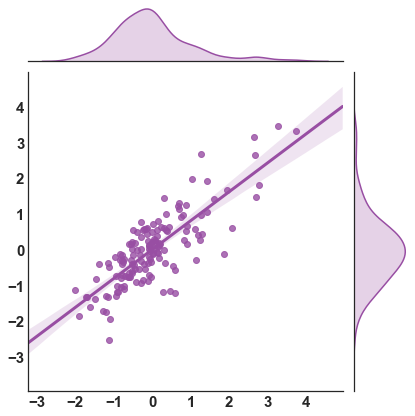

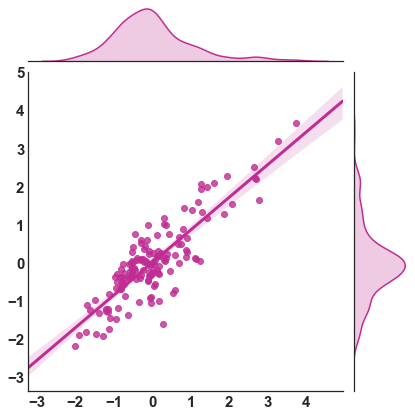

In [84]:
df = df_MU.copy(deep=True)
df = df.drop([i for i in df.index if i not in str_coords.index],axis=0)

fname = 'mean'
for roi in ['IRON_T2']:
    dfx_iron_t2 = make_corr(df,roi, 'ANMC', M[0], (65,1.4),   fname=fname)
    dfx_iron_t2 = make_corr(df,roi, 'TCA', P[0], (65,1.4),   fname=fname)


In [45]:
#dropx=[i for i in df_PC2.index if i not in str_coords.index]
#sns.jointplot(df_MU.drop(dropx,axis=0).ANMC, df_MU.drop(dropx).IRON_T2, kind = 'reg', color=M[0])
#sns.jointplot(df_MU.drop(dropx,axis=0).TCA, df_MU.drop(dropx).IRON_T2, kind = 'reg', color=P[0])


In [46]:
len(df_PC2.drop(dropx,axis=0))

146

IRON_T2 ANMC 0.22 0.0068167625
IRON_T2 TCA 0.17 0.0354763062


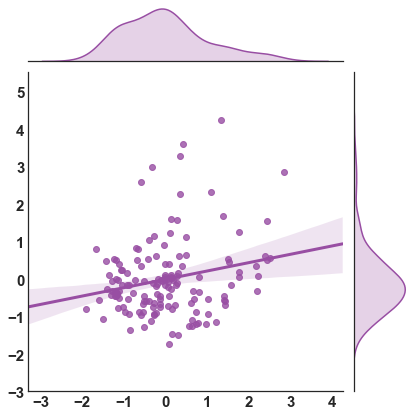

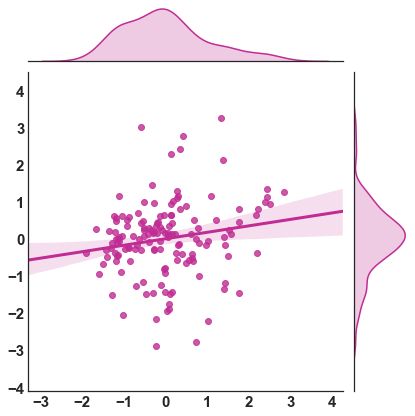

In [47]:
df = df_PC2.copy(deep=True)
df = df.drop([i for i in df.index if i not in str_coords.index],axis=0)

fname = None
for roi in ['IRON_T2']:
    dfx_iron_t2 = make_corr(df,roi, 'ANMC', M[0], (65,1.4),   fname=fname)
    dfx_iron_t2 = make_corr(df,roi, 'TCA', P[0], (65,1.4),   fname=fname)


# Permutations 

* To statisticaly evaluate the observed correlations, we examined whether an observed correlation was higher than one could expect under the null-condition.
* The observed correlation for a specific geneset/susceptibilit correlation was tested against a null distribution of correlations.
* 10,000 permutations were used. 
* For each permutation, expression values were extracted from a similar number of genes. 
* The null hypothesis at the 5% FDR-adjusted significance level correcting for multiple testing of X-comparisons. 

In [48]:
# Read AHBA database 
AHBA = pd.read_csv(os.path.join(ahba_dir, 'ahba_data', 'AHBA_20737.csv'), index_col = 0)

In [49]:
df_AHBA = AHBA
df_stats_mu = pd.DataFrame(index = ['r_val', 'p_val', 'p_fdr']).T
df_stats_md = pd.DataFrame(index = ['r_val', 'p_val', 'p_fdr']).T
df_stats_pc = pd.DataFrame(index = ['r_val', 'p_val', 'p_fdr']).T

In [65]:
# permutations for assessing significance 
def permute(df_stats, dfname, met1, met2,  color1, npermutations = 1000, pc2=None):
    
    df_INT  = dfs[dfname]
    geneset = genesets[met1]
    
    
    #####################
    ## Get correlation of interest 

    # Concat susceptibility and gene expression columns into new dataframe
    df_int = pd.DataFrame(index = df_INT.index)
    df_int['GEN'] = df_INT[met1]
    df_int['CHI'] = df_INT[met2]
    df_int        = df_int.drop(drop_wells,axis=0).dropna()
    
    if pc2:
        df_INT2  = dfs['df_PC2']
        df_int['GEN'] = df_INT2[met1]
        
    # Pearson Correlation between susceptibility and gene expression
    observed_correlation = np.round(pearsonr(df_int['CHI'], df_int['GEN'])[0],2)
    
    #########################
    ## Run 10,000 permutations 
    
    fname = os.path.join(permute_dir, 'null_distribution_%s_%s_%s_%sperm.npy'%(dfname[3:], met2, met1, npermutations))
    if not os.path.isfile(fname):
        # Get all gene names in AHBA database (drop contents of geneset and metadata strings)
        #GENES = df_AHBA.drop(drop_strings+geneset, axis = 1).columns
        GENES = df_AHBA.columns
        print '.... Total Number of AHBA genes =',len(GENES)
        print '.... Geneset of interest contains %s genes' %(len(geneset))

        # Calculate correlation between Susceptibility and a random set of genes (10000 times)
        null_distribution = []

        print '.... Running %s permutations' %npermutations
        for i in xrange(npermutations):
            GENESET_RAND = random.sample(GENES, len(geneset))

            #create new dataframe with random genes only
            #df_rand      = df_AHBA.drop([gene for gene in geneset if gene in GENES] + 
            #                            [gene for gene in GENES if gene not in GENESET_RAND],axis=1)  
            df_rand      = df_AHBA.drop([gene for gene in GENES if gene not in GENESET_RAND],axis=1)  

            # Calculate mean of the random set of genes and place into dataframe
            df_rand['CHI']  = df_INT[met2]
            df_rand['Mean'] = df_rand[GENESET_RAND].median(axis=1)
            df_rand = df_rand.dropna()
            rv = pearsonr(df_rand['CHI'], df_rand['Mean'])
            #print rv[0]
            null_distribution.append(rv[0])

        np.save(fname, null_distribution)
    
    else:
        null_distribution = np.load(fname)
    
    # Get pval     
    right = np.sum(np.array([np.abs(i) for i in null_distribution if i > observed_correlation]))
    xsum  = np.sum(np.abs(np.array(null_distribution)))
    p_val = right/xsum
    print '%s vs %s R_val= %s, P_val=%s' %(met2[0:8], met1, observed_correlation,  np.round(np.array(p_val), 10))
    
    df_stats.loc['%s_corr_%s'%(met2[0:8], met1), 'r_val'] = observed_correlation
    df_stats.loc['%s_corr_%s'%(met2[0:8], met1), 'p_val'] = np.round(p_val,4)
    
    return  observed_correlation, null_distribution

In [66]:
nperm = 10000
gsets = ['ANMC','TCA']

In [67]:
for gset in gsets:
    _,_ = permute(df_stats_mu, 'df_MU', gset, 'IRON_H', color1= M[0], npermutations = nperm)
    _,_ = permute(df_stats_mu, 'df_MU', gset, 'IRON_D', color1= M[0], npermutations = nperm)
    _,_ = permute(df_stats_mu, 'df_MU', gset, 'IRON_T2', color1= M[0], npermutations = nperm)
    _,_ = permute(df_stats_mu, 'df_MU', gset, 'FERRITIN', color1= M[0], npermutations = nperm)

IRON_H vs ANMC R_val= 0.52, P_val=0.1332852186
IRON_D vs ANMC R_val= 0.61, P_val=0.0815228965
IRON_T2 vs ANMC R_val= 0.8, P_val=0.0003781172
FERRITIN vs ANMC R_val= 0.46, P_val=0.2933710275
IRON_H vs TCA R_val= 0.43, P_val=0.3494880889
IRON_D vs TCA R_val= 0.52, P_val=0.2766146404
IRON_T2 vs TCA R_val= 0.79, P_val=0.0012844518
FERRITIN vs TCA R_val= 0.42, P_val=0.4306773657


In [71]:
for gset in gsets:
    #_,_ = permute(df_stats_pc, 'df_PC1', gset, 'IRON_H', color1= M[0], npermutations = nperm,pc2=True)
    #_,_ = permute(df_stats_pc, 'df_PC1', gset, 'IRON_D', color1= M[0], npermutations = nperm,pc2=True)
    _,_ = permute(df_stats_pc, 'df_PC1', gset, 'IRON_T2', color1= M[0], npermutations = nperm,pc2=True)
    #_,_ = permute(df_stats_pc, 'df_PC1', gset, 'FERRITIN', color1= M[0], npermutations = nperm,pc2=True)

.... Total Number of AHBA genes = 20750
.... Geneset of interest contains 39 genes
.... Running 10000 permutations
IRON_T2 vs ANMC R_val= 0.81, P_val=0.0005450932
.... Total Number of AHBA genes = 20750
.... Geneset of interest contains 36 genes
.... Running 10000 permutations
IRON_T2 vs TCA R_val= 0.03, P_val=0.9739166956


In [73]:
def make_fdr(df_stats):
    df_stats = df_stats.sort_values('p_val')
    df_stats['p_fdr'] = fdrcorrection0(df_stats.p_val)[1]
    return df_stats.sort_values('p_fdr')

In [74]:
make_fdr(df_stats_mu)

,r_val,p_val,p_fdr
IRON_T2_corr_ANMC,0.80,0.0004,0.003200
IRON_T2_corr_TCA,0.79,0.0013,0.005200
IRON_D_corr_ANMC,0.61,0.0815,0.217333
IRON_H_corr_ANMC,0.52,0.1333,0.266600
IRON_D_corr_TCA,0.52,0.2766,0.391200
FERRITIN_corr_ANMC,0.46,0.2934,0.391200
IRON_H_corr_TCA,0.43,0.3495,0.399429
FERRITIN_corr_TCA,0.42,0.4307,0.430700


In [75]:
make_fdr(df_stats_pc)

,r_val,p_val,p_fdr
IRON_T2_corr_ANMC,0.81,0.0005,0.0040
IRON_H_corr_ANMC,0.70,0.0185,0.0740
FERRITIN_corr_ANMC,0.62,0.0459,0.1224
IRON_D_corr_ANMC,0.60,0.0809,0.1618
IRON_D_corr_TCA,0.18,0.9388,0.9921
IRON_T2_corr_TCA,0.03,0.9739,0.9921
IRON_H_corr_TCA,0.07,0.9902,0.9921
FERRITIN_corr_TCA,0.03,0.9921,0.9921


In [72]:
R_NULL_T2_ANMC,MU_NULL_T2_ANMC= permute(df_stats_mu, 'df_MU', 'ANMC', 'IRON_T2', color1= M[0], npermutations = nperm)
R_NULL_T2_TCA,MU_NULL_T2_TCA= permute(df_stats_mu, 'df_MU', 'TCA', 'IRON_T2', color1= M[0], npermutations = nperm)


IRON_H vs ANMC R_val= 0.52, P_val=0.1332852186
IRON_D vs ANMC R_val= 0.61, P_val=0.0815228965
IRON_T2 vs ANMC R_val= 0.8, P_val=0.0003781172
FERRITIN vs ANMC R_val= 0.46, P_val=0.2933710275
IRON_H vs TCA R_val= 0.43, P_val=0.3494880889
IRON_D vs TCA R_val= 0.52, P_val=0.2766146404
IRON_T2 vs TCA R_val= 0.79, P_val=0.0012844518
FERRITIN vs TCA R_val= 0.42, P_val=0.4306773657


In [81]:
def plt_permutation(mu_corr, pc_corr, null_distribution, color1, fname):

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    #sns.set(style="white", palette="muted", color_codes=True)
    sns.set_style("white")
    g = sns.distplot(null_distribution, color=color1, hist=1, bins = 30, norm_hist=1, 
                     kde_kws={'linewidth': 2} )
    null_mu = np.mean(null_distribution)
    null_sd = np.std(null_distribution)
    null_05 = np.percentile(null_distribution, 2.5)
    null_95 = np.percentile(null_distribution, 97.5)
    
    plt.axvline(null_mu, color=color1, linestyle='-.', linewidth=1)
    #plt.axvline(np.percentile(null_distribution, 2.5), color='k', linestyle='-.', linewidth=1)
    #plt.axvline(np.percentile(null_distribution, 97.5), color='k', linestyle='-.', linewidth=1)
    plt.axvspan(null_05,null_95, alpha=0.5, color='lightgray')
        
    print null_mu
    print null_sd
    print null_05
    print null_95
    
    #plt.arrow(null_mu, 0.5, null_05, 0, fc="r", ec="r",head_width=0.1, head_length=0.01,linewidth=3)
    #plt.arrow(null_mu, 0.5, null_95, 0, fc="r", ec="r",head_width=0.01, head_length=0.01,linewidth=3)

    plt.axvline(mu_corr, color='r', linestyle=':', linewidth=3.5)
    plt.axvline(pc_corr, color='k', linestyle='-.', linewidth=3.5)

    #plt.arrow(mu_corr, 3, 0.0, -2.75, fc="r", ec="r",head_width=0.025, head_length=0.1,linewidth=3)
    #plt.arrow(pc_corr, 3, 0.0, -2.75, fc="b", ec="b",head_width=0.025, head_length=0.1,linewidth=3)
    
    plt.yticks([0,1,2,3])
    plt.xlim(-.2,1)
    plt.ylim(0,3.7)
    plt.tick_params(axis='x', pad=12)
    plt.tick_params(axis='y', pad=12)
    plt.setp(ax.spines.values(), linewidth=1.5)
    
    plt.xticks(fontsize=15, weight='bold')
    plt.yticks(fontsize=15, weight='bold')
    
    plt.savefig(os.path.join(save_fig_dir, 'permute_STRM_%s'%fname), bbox_inches='tight', transparent=1, dpi = 300)
    


0.42802835047124155
0.15777317099960778
0.08267342374780774
0.6883343495235539
0.43630194644346937
0.16425592914749174
0.08212593662883216
0.7089376891406004


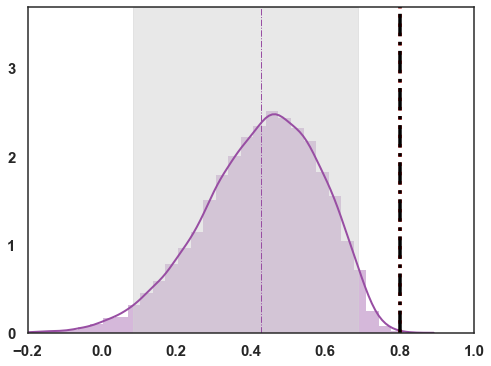

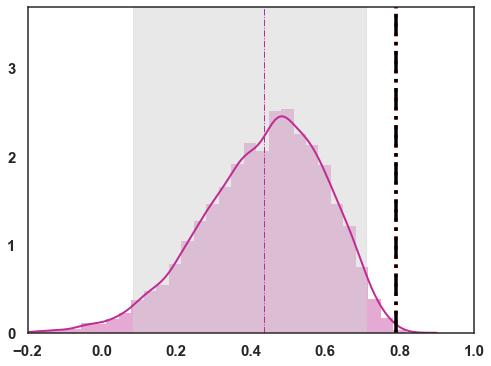

In [83]:
plt_permutation(R_NULL_T2_ANMC, R_NULL_T2_ANMC, MU_NULL_T2_ANMC, M[0], 'IRON_T2_ANMC'  )
plt_permutation(R_NULL_T2_TCA, R_NULL_T2_TCA, MU_NULL_T2_TCA, P[0], 'IRON_T2_TCA'  )
